In [1]:
import params
from google.cloud import datastore, storage, logging
import time
import pickle
import hashlib
import sys
import numpy as np
import portfolioGeneration
import portfolio
import dataAck
import warnings
import numpy as np
import pandas as pd
warnings.filterwarnings("ignore")
from IPython.display import display


In [7]:
## GET ALL MODELS
allModels = [item["model"] for item in portfolio.getModels(ticker=None, returnEntireObject=True)]
for i in range(len(allModels)):
    model = allModels[i]
    print(model.describe())

((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 300)
((5, ('FXE', 29, 13, None, 1), 7, 'SPY'), 5, 50)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 150)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 50)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 50)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 50)
((10, ('USO', 19, 9, 8, 2), 15, 'IWB'), 10, 150)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 150)
((5, ('FXE', 29, 13, None, 1), 15, 'SPY'), 5, 100)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 150)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 25)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 25)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 100)
((5, ('FXE', 39, None, 10, 3), 7, 'IWB'), 5, 100)
((5, ('IYT', 12, 16, 8, 2), 5, 'FXE'), 5, 100)
((5, ('IYR', 19, 20, 21, 3), 7, 'IAU'), 5, 50)
((10, ('FXE', 29, 13, None, 1), 5, 'SPY'), 10, 25)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 100)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 150)
((5, ('SHY', 1, None, 5, 1), 

In [8]:
def generateAllReturnsFromCache(allModels):
    aggregateReturns = None
    aggregatePredictions = None
    aggregateSlippageReturns = None
    cleanedModels = []
    for mod in allModels:
        
        try:
            algoReturn, algoPredictions, algoSlippageAdjustedReturn = dataAck.getModelData(mod)
            print(mod.describe())
            algoReturn.columns = [str(mod.describe())]
            algoPredictions.columns = [str(mod.describe())]
            algoSlippageAdjustedReturn.columns =  [str(mod.describe())]
            if aggregateReturns is None:
                aggregateReturns = algoReturn
                aggregatePredictions = algoPredictions
                aggregateSlippageReturns = algoSlippageAdjustedReturn
            else:
                aggregateReturns = aggregateReturns.join(algoReturn)
                aggregatePredictions = aggregatePredictions.join(algoPredictions)
                aggregateSlippageReturns = aggregateSlippageReturns.join(algoSlippageAdjustedReturn)
            cleanedModels.append(mod)
        except:
            print("SKIPPING", mod.describe())
    return aggregateReturns, aggregatePredictions, aggregateSlippageReturns, cleanedModels

def computeReturnsForUniqueModelsCache(uniqueModels, factorToTrade):
    tickersRequired = []
    for mod in uniqueModels:

        print(mod.describe())
        if mod.inputSeries.targetTicker not in tickersRequired:
            tickersRequired.append(mod.inputSeries.targetTicker)
            
    if factorToTrade not in tickersRequired:
        tickersRequired.append(factorToTrade)
    
    pulledData, validTickers = dataAck.downloadTickerData(tickersRequired)

    joinedData = dataAck.joinDatasets([pulledData[ticker] for ticker in pulledData])
    
    modelReturns, modelPredictions, modelSlippageReturns, cleanedModels = generateAllReturnsFromCache(uniqueModels)
    
    return cleanedModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturns.join(dataAck.getDailyFactorReturn(factorToTrade, joinedData)).dropna(), joinedData

In [9]:
factorToTrade = "SPY"
uniqueModels, modelReturns, modelPredictions, modelSlippageReturns, modelReturnsWithFactor, joinedData =\
    computeReturnsForUniqueModelsCache(allModels, factorToTrade)

((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 300)
((5, ('FXE', 29, 13, None, 1), 7, 'SPY'), 5, 50)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 150)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 50)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 50)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 50)
((10, ('USO', 19, 9, 8, 2), 15, 'IWB'), 10, 150)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 150)
((5, ('FXE', 29, 13, None, 1), 15, 'SPY'), 5, 100)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 150)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 25)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 25)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 100)
((5, ('FXE', 39, None, 10, 3), 7, 'IWB'), 5, 100)
((5, ('IYT', 12, 16, 8, 2), 5, 'FXE'), 5, 100)
((5, ('IYR', 19, 20, 21, 3), 7, 'IAU'), 5, 50)
((10, ('FXE', 29, 13, None, 1), 5, 'SPY'), 10, 25)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 100)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 150)
((5, ('SHY', 1, None, 5, 1), 

In [54]:
cleanedReturns = modelReturns.dropna()
cleanedReturns.columns = [portfolio.getModelHash(item) for item in allModels]
cleanedPredictions = modelPredictions.dropna()
cleanedPredictions.columns = [portfolio.getModelHash(item) for item in allModels]
hashToModel = {}
for item in allModels:
    hashToModel[portfolio.getModelHash(item)] = item

In [25]:
display(cleanedReturns)

,0724944db3ce71de7023be74ae483f9fa0e50ecc3301443a85f9e7b4,0bf26d94dfb9569efaf93627fe41c8271144a095bbe91409aa8c462e,1b2d65178501b029c40fc114ad34ad655d26939cdb0d8afe2650f394,2a382440afde41d85f32097e403783bdaac0731aacbefd175aefd0a5,41f545f5052522463eebac5395473eb13b3a3d4b74d159ed78ebf518,5a677a2d61d4f219955dd820efa9894ee06148f7be83f30a28fe4423,5d2d1a5d9c4e517f3e7077c6c8cb23e62f92a7e86c0a169958507c72,6ddf72f98598480cf2a3286f3add6e33399b89d718c8ea9f0e001bb9,6e5d77d7c68327ea28044db3c78d2792af21a05e100761ef9ce26393,718b080bbcf7c87e4e2a917227fb13daff19ec8aa8026aec5e721fcc,...,b0613d3746a093aa2956d0605cfa196e4d9b222e542892e39aa324d6,c64dbbdf99c3baea7cba65a883f9e6cbf54d6f3d5fe34c0b469e102a,c93266797c4270883fbc716a65bc21aaf122cd10a2800b79606d264f,c9fd8d9ac3f6319af25d5b47e9000d1ee3ad571fae9fe88bcbb3b100,cf5f959c332fe7230c0d0559a825a5445e85c08aca1ce254dcfecd16,d13acf9ac1db028b00b4ba552ad982feecff0be3b7f0e2f96106f467,dbab84a8431a5c7315448d90fc4b687e81979b994b6a2a48b9628118,e61f528a15a34015825d90cd74731bd9380f9f07acbedfa1c0acd733,ebcf9a83e10c6df5a108fd5e506e595c3729784f77e72b4ecdd40db6,f3b3f63fefa2e2efc5af630c65f50713b6d229c5ede1526c31c8714b
2009-02-25,0.006098,-0.002033,0.002033,-0.002419,2.838038e-04,0.000590,-0.002073,-0.000970,0.008147,-0.005586,...,0.000737,0.008600,-0.003303,-0.000243,-0.003176,-0.008466,0.000565,-0.002176,-0.001524,0.010863
2009-02-26,0.012571,-0.002095,0.005587,-0.003509,4.523173e-04,0.000524,-0.003048,-0.000000,0.013302,-0.007629,...,0.001572,0.012977,-0.003492,-0.000646,-0.003754,-0.011590,-0.000883,-0.003171,-0.001397,0.016870
2009-02-27,0.030967,-0.000704,0.022521,-0.008606,8.821805e-04,-0.000000,-0.007569,-0.002915,0.022315,-0.015272,...,0.005531,0.021695,-0.002111,-0.002186,-0.006510,-0.023247,-0.000508,-0.007809,-0.001408,0.030994
2009-03-02,0.006099,0.000938,0.004692,-0.001513,1.751342e-04,-0.001360,-0.001348,-0.000473,0.005609,-0.002532,...,0.002039,0.005453,0.000469,-0.000473,-0.001056,-0.003856,0.000119,-0.001378,0.000938,0.007479
2009-03-03,-0.019249,-0.004442,-0.013326,0.005312,-1.756334e-04,-0.003999,0.004793,0.001540,-0.011016,0.007957,...,-0.000000,-0.009757,-0.003702,0.002311,0.002869,0.012114,0.000546,0.004859,-0.004442,-0.015108
2009-03-04,0.033189,0.008935,0.028083,-0.009687,2.371144e-04,0.016841,-0.008847,-0.007839,0.020889,-0.013665,...,0.004210,0.018278,0.009574,-0.005880,-0.004468,-0.020788,-0.000771,-0.008896,0.010212,0.028723
2009-03-05,-0.001417,-0.000409,-0.001199,0.000743,-1.215033e-07,0.002118,0.000686,0.000560,-0.002050,0.000581,...,0.001324,-0.001688,-0.000382,0.000514,0.000177,0.000883,0.000746,0.000685,-0.000491,-0.002411
2009-03-06,0.007345,0.002387,0.005876,-0.003406,-3.574714e-05,-0.012167,-0.003182,-0.004004,0.006415,-0.003915,...,-0.009734,0.004811,0.002755,-0.002603,-0.001056,-0.005924,-0.000534,-0.003152,0.002938,0.007618
2009-03-09,-0.029805,-0.012108,-0.022354,0.017520,8.545736e-04,-0.016683,0.016557,0.023204,-0.022257,0.019832,...,-0.013347,-0.015898,-0.013040,0.015469,0.005123,0.029899,0.001735,0.016285,-0.014902,-0.025436
2009-03-10,-0.002849,-0.001323,-0.002442,0.001197,5.970417e-06,0.005440,0.001144,0.002238,-0.000331,0.002165,...,0.006120,-0.000243,-0.001221,0.001057,0.000636,0.003248,0.004264,0.001117,-0.001628,-0.000309


In [26]:
display(cleanedPredictions)

,0724944db3ce71de7023be74ae483f9fa0e50ecc3301443a85f9e7b4,0bf26d94dfb9569efaf93627fe41c8271144a095bbe91409aa8c462e,1b2d65178501b029c40fc114ad34ad655d26939cdb0d8afe2650f394,2a382440afde41d85f32097e403783bdaac0731aacbefd175aefd0a5,41f545f5052522463eebac5395473eb13b3a3d4b74d159ed78ebf518,5a677a2d61d4f219955dd820efa9894ee06148f7be83f30a28fe4423,5d2d1a5d9c4e517f3e7077c6c8cb23e62f92a7e86c0a169958507c72,6ddf72f98598480cf2a3286f3add6e33399b89d718c8ea9f0e001bb9,6e5d77d7c68327ea28044db3c78d2792af21a05e100761ef9ce26393,718b080bbcf7c87e4e2a917227fb13daff19ec8aa8026aec5e721fcc,...,b0613d3746a093aa2956d0605cfa196e4d9b222e542892e39aa324d6,c64dbbdf99c3baea7cba65a883f9e6cbf54d6f3d5fe34c0b469e102a,c93266797c4270883fbc716a65bc21aaf122cd10a2800b79606d264f,c9fd8d9ac3f6319af25d5b47e9000d1ee3ad571fae9fe88bcbb3b100,cf5f959c332fe7230c0d0559a825a5445e85c08aca1ce254dcfecd16,d13acf9ac1db028b00b4ba552ad982feecff0be3b7f0e2f96106f467,dbab84a8431a5c7315448d90fc4b687e81979b994b6a2a48b9628118,e61f528a15a34015825d90cd74731bd9380f9f07acbedfa1c0acd733,ebcf9a83e10c6df5a108fd5e506e595c3729784f77e72b4ecdd40db6,f3b3f63fefa2e2efc5af630c65f50713b6d229c5ede1526c31c8714b
2009-02-25,-0.3750,0.125000,-0.1250,0.155823,-0.020081,-0.2500,0.133545,0.0625,-0.562500,0.343506,...,-0.3125,-0.593750,0.203125,0.015625,0.195312,0.520630,0.3125,0.140137,0.09375,-0.750000
2009-02-26,-0.5625,0.093750,-0.2500,0.169800,-0.018188,-0.1250,0.147522,0.0000,-0.640625,0.341370,...,-0.3750,-0.625000,0.156250,0.031250,0.167969,0.518616,0.1875,0.153442,0.06250,-0.812500
2009-02-27,-0.6875,0.015625,-0.5000,0.184509,-0.015808,0.0000,0.162292,0.0625,-0.562500,0.339050,...,-0.3125,-0.546875,0.046875,0.046875,0.144531,0.516113,0.0625,0.167419,0.03125,-0.781250
2009-03-02,-0.8125,-0.125000,-0.6250,0.199890,-0.012817,0.1250,0.177979,0.0625,-0.562500,0.337219,...,-0.1875,-0.546875,-0.062500,0.062500,0.140625,0.513611,0.1250,0.181946,-0.12500,-0.750000
2009-03-03,-0.8125,-0.187500,-0.5625,0.215515,-0.009399,0.3750,0.194458,0.0625,-0.546875,0.335876,...,0.0000,-0.484375,-0.156250,0.093750,0.121094,0.511353,0.1250,0.197144,-0.18750,-0.750000
2009-03-04,-0.8125,-0.218750,-0.6875,0.231689,-0.005066,0.5000,0.211609,0.1875,-0.500000,0.334534,...,0.1250,-0.437500,-0.234375,0.140625,0.109375,0.508911,0.1250,0.212769,-0.25000,-0.687500
2009-03-05,-0.8125,-0.234375,-0.6875,0.248718,-0.000122,0.5000,0.229614,0.1875,-0.531250,0.333374,...,0.3125,-0.437500,-0.218750,0.171875,0.101562,0.506287,0.1250,0.229187,-0.28125,-0.625000
2009-03-06,-0.6250,-0.203125,-0.5000,0.265808,0.005676,0.6250,0.248352,0.3125,-0.500000,0.333130,...,0.5000,-0.375000,-0.234375,0.203125,0.089844,0.504028,0.2500,0.246033,-0.25000,-0.593750
2009-03-09,-0.5000,-0.203125,-0.3750,0.283142,0.012085,0.6250,0.267578,0.3750,-0.437500,0.332703,...,0.5000,-0.312500,-0.218750,0.250000,0.085938,0.501587,0.3125,0.263184,-0.25000,-0.500000
2009-03-10,-0.4375,-0.203125,-0.3750,0.300842,0.019165,0.5000,0.287476,0.5625,-0.468750,0.332397,...,0.5625,-0.343750,-0.187500,0.265625,0.097656,0.498718,0.3125,0.280640,-0.25000,-0.437500


COMPUTED HISTORICAL WEIGHTS


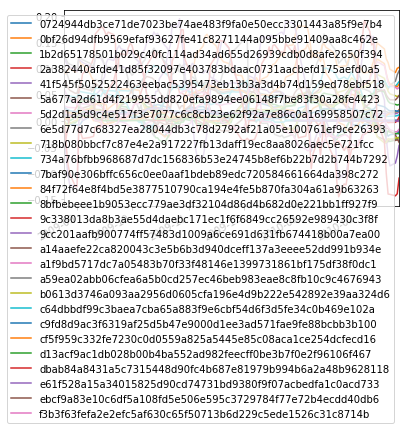

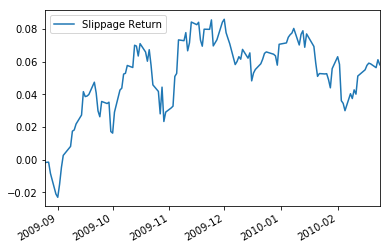

((5, ('FXE', 39, None, 10, 3), 7, 'IWB'), 5, 100)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 25)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 50)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 300)
((5, ('FXE', 29, 13, None, 1), 15, 'SPY'), 5, 300)
((10, ('FXE', 29, 13, None, 1), 10, 'SPY'), 10, 25)
((5, ('IYT', 12, 16, 8, 2), 5, 'FXE'), 5, 150)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 100)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 25)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 300)
((5, ('FXE', 29, 13, None, 1), 7, 'SPY'), 5, 25)
((10, ('FXE', 29, 13, None, 1), 5, 'SPY'), 10, 25)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 100)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 50)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 50)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 150)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 150)
((44, ('USO', 19, 9, 8, 2), 7, 'IWB'), 44, 50)
((10, ('USO', 19, 9, 8, 2), 1

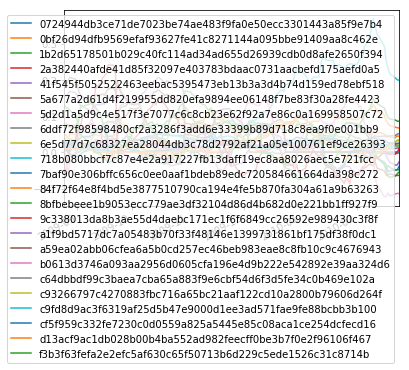

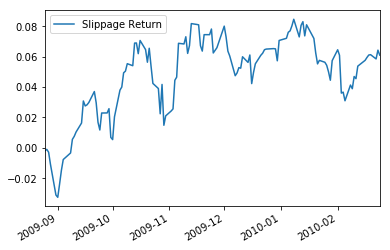

((10, ('USO', 19, 9, 8, 2), 15, 'IWB'), 10, 150)
((10, ('SHY', 1, None, 5, 1), 7, 'VIG'), 10, 100)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 150)
((5, ('FXE', 29, 13, None, 1), 15, 'SPY'), 5, 300)
((5, ('FXE', 29, 13, None, 1), 7, 'SPY'), 5, 100)
((5, ('FXE', 29, 13, None, 1), 5, 'SPY'), 5, 300)
((10, ('FXE', 29, 13, None, 1), 5, 'SPY'), 10, 25)
((5, ('FXE', 29, 13, None, 1), 7, 'SPY'), 5, 50)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 150)
((5, ('SHY', 1, None, 5, 1), 7, 'VIG'), 5, 300)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 100)
((44, ('USO', 19, 9, 8, 2), 5, 'IWB'), 44, 25)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 100)
((5, ('FXE', 29, 13, None, 1), 15, 'SPY'), 5, 100)
((5, ('IYR', 19, 20, 21, 3), 5, 'IAU'), 5, 150)
((5, ('VIG', 12, None, 8, 1), 15, 'IWD'), 5, 50)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 50)
((5, ('USO', 19, 9, 8, 2), 15, 'IWB'), 5, 25)
((44, ('USO', 19, 9, 8, 2), 7, 'IWB'), 44, 50)
((10, ('FXE', 29, 13, No

TypeError: Cannot find a common data type.

In [60]:
import matplotlib.pyplot as plt
import time
import random
while True:
    ##SELECT SOME RANDOM SUBSET OF COLUMNS
    selectedAlgorithms = np.random.choice(cleanedReturns.columns, size=random.randint(7, len(cleanedReturns.columns)), replace= False)
    thisReturn = cleanedReturns[selectedAlgorithms][:252]
    thisPredictions = cleanedPredictions[selectedAlgorithms][:252]
    hrpReturns, historicalWeights = portfolioGeneration.\
            produceHRPPredictions(thisReturn,\
            126, startIndex=None, maxWindowSize=False)
    print("COMPUTED HISTORICAL WEIGHTS")
    
    
    allocations = (historicalWeights * thisPredictions).dropna()
    
    ##GET CAPITAL USAGE
    capUsage = pd.DataFrame(allocations.apply(lambda x: sum([abs(item) for item in x]), axis=1))
    
    scaledReturns = pd.DataFrame(hrpReturns.join(capUsage, rsuffix="cap_").dropna().apply(lambda x:x[0] * 1/x[1], axis=1))
    
    
    ##SCALE ALLOCATIONS
    scaledAllocations = pd.DataFrame(allocations.apply(lambda x: [itemy/sum([abs(item) for item in x]) for itemy in x], axis=1))
    scaledAllocations.plot()
    plt.show()
    
    
    hrpReturns.columns = ["Portfolio Return"]
    hrpTransactionCost = pd.DataFrame(portfolioGeneration.estimateTransactionCost(scaledAllocations).dropna().\
                                      apply(lambda x: sum(x), axis = 1), columns=["Transaction Cost"])
#     display(hrpTransactionCost)
    hrpReturns = pd.DataFrame(scaledReturns.join(hrpTransactionCost).dropna()\
                              .apply(lambda x:x[0] - x[1], axis=1), columns=["Slippage Return"])
    empyrical.cum_returns(hrpReturns).plot()
    plt.show()
    
    tickersSeen = {}
    
    for modelHash in selectedAlgorithms:
        thisModel = hashToModel[modelHash]
        print(thisModel.describe())
        if thisModel.inputSeries.targetTicker not in tickersSeen:
            tickersSeen[thisModel.inputSeries.targetTicker] = 0
        tickersSeen[thisModel.inputSeries.targetTicker] += 1
    
    for tick in tickersSeen:
        tickersSeen[tick] = round(tickersSeen[tick]/float(len(selectedAlgorithms)), 2)
    print("Tickers Used", len(list(tickersSeen.keys())), tickersSeen,
          "SHARPE", empyrical.sharpe_ratio(hrpReturns), \
          "Annual Return", empyrical.annual_return(hrpReturns)[0],
          "Annual Volatility", empyrical.annual_volatility(hrpReturns))